# Adding Transformers

This model is an attempt to implement the [TabTransformer](https://github.com/lucidrains/tab-transformer-pytorch).

I will develop the model in [keras_pp_dense_forecasting notebook](https://github.com/CahidArda/internship-study/blob/main/notebooks/rnn/keras_pp_dense_forecasting.ipynb)

Here is the diagram of the model:

<img src="imgs/modelDiagram.png">


In [52]:
import matplotlib.pyplot as plt

sys.path.append(r'../atm_demand')
from feature_generation import *

#from sklearn.model_selection import train_test_split

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Importing and Formatting Data

In [53]:
df = pd.read_csv("../atm_demand/DATA_sample_atm.csv")
targets = ['CashIn', 'CashOut']
atm_df = get_atm(df, 26637)
atm_df = atm_df[:-135]
atm_df = clean_data(atm_df, drop_zeros=True)
atm_feature_set = get_feature_sets(atm_df, ['CashIn', 'CashOut'])

dokümantasyon, google format
farklı transformer implementation, 
attention is all you need
unit testing

In [54]:
aggregate_df = df.groupby('HistoryDate').mean()
aggregate_df = aggregate_df[:-135]
aggregate_df = clean_data(aggregate_df, drop_zeros=True)
aggregate_feature_set = get_feature_sets(aggregate_df, ['CashIn', 'CashOut'])

In [55]:
atm_feature_set.columns

Index(['CashIn', 'CashOut', 'CashIn_average_7', 'CashIn_average_30',
       'CashOut_average_7', 'CashOut_average_30', 'CashIn_trend_7',
       'CashOut_trend_7', 'CashIn_t-1', 'CashIn_t-2', 'CashIn_t-3',
       'CashIn_t-4', 'CashIn_t-5', 'CashIn_t-6', 'CashIn_t-7', 'CashIn_t-8',
       'CashIn_t-9', 'CashIn_t-10', 'CashIn_t-11', 'CashIn_t-12',
       'CashIn_t-13', 'CashIn_t-14', 'CashOut_t-1', 'CashOut_t-2',
       'CashOut_t-3', 'CashOut_t-4', 'CashOut_t-5', 'CashOut_t-6',
       'CashOut_t-7', 'CashOut_t-8', 'CashOut_t-9', 'CashOut_t-10',
       'CashOut_t-11', 'CashOut_t-12', 'CashOut_t-13', 'CashOut_t-14',
       'CashOut_t-15', 'CashOut_t-16', 'CashOut_t-17', 'CashOut_t-18',
       'CashOut_t-19', 'CashOut_t-20', 'CashOut_t-21', 'CashOut_t-22',
       'CashOut_t-23', 'CashOut_t-24', 'CashOut_t-25', 'CashOut_t-26',
       'CashOut_t-27', 'CashOut_t-28', 'CashOut_t-29', 'CashOut_t-30',
       'CashOut_t-31', 'CashOut_t-32', 'CashOut_t-33', 'CashOut_t-34',
       'CashOut_t-35', '

daha basic bir model ile dene, sonra transformera gec
son 3 gün average, window statistics
catboost ile feature importance
    train/test pool
    cat/num seperately
time series clustering
    belli bir zaman aralığında her bir günün 
    atm sayısı x günler (softmax)
    cluster haftanın, ayın gününe göre farklı clusterlar,
    kmeans
    cluster sayısını dene
    çrş'ya kadar

In [56]:
one_hots     = []
categoricals = ['Day_of_the_Week_Index', 'Day_of_the_Month_Index',
       'Week_of_the_Year_Index', 'Is_Weekday', 'Special_Dates_Index',
       'is_cocuk_bayrami', 'is_isci_bayrami', 'is_spor_bayrami',
       'is_zafer_bayrami', 'is_cumhuriyet_bayrami']
numericals   = ['CashIn_average_7', 'CashIn_average_30',
       'CashOut_average_7', 'CashOut_average_30', 'CashIn_trend_7',
       'CashOut_trend_7', 'CashIn_t-1', 'CashIn_t-2', 'CashIn_t-3',
       'CashIn_t-4', 'CashIn_t-5', 'CashIn_t-6', 'CashIn_t-7', 'CashIn_t-8',
       'CashIn_t-9', 'CashIn_t-10', 'CashIn_t-11', 'CashIn_t-12',
       'CashIn_t-13', 'CashIn_t-14', 'CashOut_t-1', 'CashOut_t-2',
       'CashOut_t-3', 'CashOut_t-4', 'CashOut_t-5', 'CashOut_t-6',
       'CashOut_t-7', 'CashOut_t-8', 'CashOut_t-9', 'CashOut_t-10',
       'CashOut_t-11', 'CashOut_t-12', 'CashOut_t-13', 'CashOut_t-14',
       'CashOut_t-15', 'CashOut_t-16', 'CashOut_t-17', 'CashOut_t-18',
       'CashOut_t-19', 'CashOut_t-20', 'CashOut_t-21', 'CashOut_t-22',
       'CashOut_t-23', 'CashOut_t-24', 'CashOut_t-25', 'CashOut_t-26',
       'CashOut_t-27', 'CashOut_t-28', 'CashOut_t-29', 'CashOut_t-30',
       'CashOut_t-31', 'CashOut_t-32', 'CashOut_t-33', 'CashOut_t-34',
       'CashOut_t-35', 'CashOut_t-36', 'CashOut_t-37', 'CashOut_t-38',
       'CashOut_t-39', 'CashOut_t-40']

groups = [one_hots, numericals]
groups.extend(categoricals)

In [57]:
def train_test_split(X, y, split=0.2):
    cut = int(X.shape[0] * split)
    return X[:-cut], X[-cut:], y[:-cut], y[-cut:]

def get_input_sets(df, groups):
    result = []
    for group in groups:
        result.append(df[group])
    return result

In [58]:
TARGET = 'CashIn'
X_train, X_test, y_train, y_test = train_test_split(atm_feature_set[atm_feature_set.columns[2:]], atm_feature_set[TARGET])

train_inputs = get_input_sets(X_train, groups)
test_inputs  = get_input_sets(X_test, groups)

In [59]:
X_pretrain, X_pretest, y_pretrain, y_pretest = train_test_split(aggregate_feature_set[aggregate_feature_set.columns[2:]], aggregate_feature_set[TARGET])

pretrain_inputs = get_input_sets(X_pretrain, groups)
pretest_inputs  = get_input_sets(X_pretest, groups)

targeta log transformation uygula

## Building the Model

### Preprocessing

In [60]:
one_hot_inputs = layers.Input(shape=[len(one_hots)])

numeric_inputs        = layers.Input(shape=[len(numericals)])
numeric_inputs_normal = layers.LayerNormalization()(numeric_inputs)

### Categoricals

In [61]:
EMBED_DIM = 16

categorical_inputs = []
embedding_outputs  = []
for size in [len(atm_feature_set[categorical].unique()) for categorical in categoricals]:
    input_layer          = layers.Input(shape=[1])
    input_layer_embedded = layers.Embedding(input_dim=size, output_dim=EMBED_DIM)(input_layer)
    categorical_inputs.append(input_layer)
    embedding_outputs.append(input_layer_embedded)

embeddeds = layers.Concatenate(axis=1)(embedding_outputs)

### Transformer

In [62]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        # parametreleri
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        # batch-layer
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [63]:
HEADS   = 8
DEPTH   = 6

transformer = embeddeds
for _ in range(DEPTH):
    transformer = TransformerBlock(EMBED_DIM, HEADS, EMBED_DIM)(transformer)
transformer_flat = layers.Flatten()(transformer)

### Concatenation

In [64]:
concatenated = layers.Concatenate()([one_hot_inputs, numeric_inputs_normal, transformer_flat])

### MLP

In [65]:
'''
l = concatenated.shape[1] // 8

MLP_HIDDEN_RATIOS = [4,2,2]
ACTIVATIONS = ['relu', 'relu', 'selu']
mlp_layer = concatenated
for ratio, activation in zip(MLP_HIDDEN_RATIOS, ACTIVATIONS):
    mlp_layer = layers.Dropout(0.1)(mlp_layer)
    #mlp_layer = layers.LayerNormalization()(mlp_layer)
    mlp_layer = layers.Dense(ratio * l, activation=activation)(mlp_layer)
output_layer = layers.Dense(1)(mlp_layer)
'''

"\nl = concatenated.shape[1] // 8\n\nMLP_HIDDEN_RATIOS = [4,2,2]\nACTIVATIONS = ['relu', 'relu', 'selu']\nmlp_layer = concatenated\nfor ratio, activation in zip(MLP_HIDDEN_RATIOS, ACTIVATIONS):\n    mlp_layer = layers.Dropout(0.1)(mlp_layer)\n    #mlp_layer = layers.LayerNormalization()(mlp_layer)\n    mlp_layer = layers.Dense(ratio * l, activation=activation)(mlp_layer)\noutput_layer = layers.Dense(1)(mlp_layer)\n"

In [66]:
dropout1        = layers.Dropout(0.2)(concatenated)
normalization1  = layers.LayerNormalization()(dropout1)
dense1          = layers.Dense(128, activation='relu')(normalization1)
dropout2        = layers.Dropout(0.2)(dense1)
normalization2  = layers.LayerNormalization()(dropout2)
dense2          = layers.Dense(32, activation='relu')(normalization2)
exponential     = layers.Dense(16, activation='relu')(dense2)
output_layer    = layers.Dense(1)(exponential)

In [67]:
inputs = [one_hot_inputs, numeric_inputs]
inputs.extend(categorical_inputs)
model = keras.Model(inputs=inputs, outputs=[output_layer])

### Summary

In [68]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_28 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_29 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_30 (InputLayer)           [(None, 1)]          0                                            
____________________________________________________________________________________________

## Training

In [69]:
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.005),
    loss='mape')

In [70]:
history = model.fit(train_inputs, 
            y_train,
            batch_size=32,
            epochs=100,
            validation_data=(test_inputs, y_test),
            verbose = 0)

In [77]:
def plot_history(history):
    plt.figure(figsize=(10,4))
    for key in history.history:
        if key in ['loss', 'val_loss']:
            continue
        plt.plot(history.history[key][3:], label = key)
    plt.legend()
    plt.show()

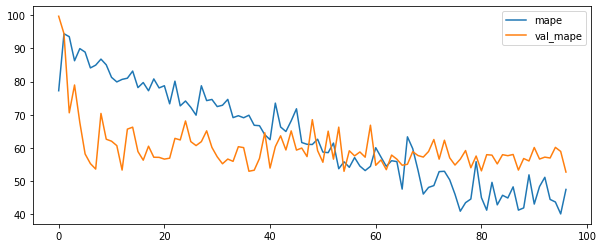

In [78]:
plot_history(history)

In [79]:
"min_loss: %.4f, min_val_loss: %.4f" % (min(history.history['mape']), min(history.history['val_mape']))

'min_loss: 40.0327, min_val_loss: 39.6993'

### Comparing with Previous Methods

| Model | Train Error | Test Error | All Set Error |
| - | - | - | - |
| Base | - | - | 78.8 |
| Random Forest | 23.9 | 47.0 | - |
| LGBM | - | 48.7 | - |
| TF Custom RNN | - | - | 70.7 |
| Keras, PP + Dense (with one dropout layer) | 21.7 | 37.8 | - |
| Keras, PP + Dense (with two dropout layers) | 25.3 | 36.9 | - |
| Keras, PP + Dense [1] | 18.9 | 35.5 | - |
| Keras, PP + Dense [2] | 18.5 | 34.7 | - |
| Keras, PP + Transformer + Dense [2] | 28.6 | 36.5 | - |

* [1]: dropout, layer-norm, dense (128, relu), dropout, layer-norm, dense (32, relu), dense (16, relu), dense (16, **selu**), dense (1)
* [2]: dropout, layer-norm, dense (128, relu), dropout, layer-norm, dense (32, relu), dropout, layer-norm, dense (16, **selu**), dense (16, **selu**), dense (1)

In [74]:
from forecasting import get_error_with_freq
from plotting import draw_error_over_time

In [75]:
def draw_model_error(model, X, y_actual, error_freq='w', split_from=None):

    y_pred = pd.Series(model.predict(X).reshape(-1), index=y_actual.index)
    weekly_errors = get_error_with_freq(y_actual, y_pred, error_freq)
    draw_error_over_time(y_actual, y_pred, weekly_errors, split_from)

In [76]:
draw_model_error(model, get_input_sets(atm_feature_set[atm_feature_set.columns[2:]], groups), atm_feature_set[TARGET], split_from=X_train.index[-1])